In [2]:
import pandas as pd
from selenium import webdriver 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException
from multiprocessing.dummy import Pool as ThreadPool
import itertools
import time

In [32]:
def striplist(list):
    return([x.replace(' ', '') for x in list])

In [3]:
def startDriver(file_path):
    option = webdriver.ChromeOptions()
    option.add_argument(" — incognito")
    browser = webdriver.Chrome(executable_path=file_path)
    browser.get("https://coinmarketcap.com/exchanges/bitmax/")
    return browser

In [4]:
def getUrls(browser):
    """
    Tworzy listę urli, które prowadzą do tabeli z historycznymi danymi
    dla każdej waluty.
    """
    urls = []
    infos = browser.find_elements_by_class_name('margin-left--lv1')
    urls = [(url.get_attribute("href") + "historical-data") for url in infos]
    return urls

In [10]:
import re
# urls = getUrls(startDriver('C:\\chromedriver.exe'))
mainUrls = []
for item in urls:
    if re.search("bitcoin/|paxos|ethereum/|usd-coin", item):
        mainUrls.append(item)
mainUrls = set(mainUrls)
print(mainUrls)

{'https://coinmarketcap.com/currencies/paxos-standard-token/historical-data', 'https://coinmarketcap.com/currencies/bitcoin/historical-data', 'https://coinmarketcap.com/currencies/ethereum/historical-data', 'https://coinmarketcap.com/currencies/usd-coin/historical-data'}


In [ ]:
def currHistory(browser, url):
    """
    Ustawia przeglądarke na danym url'u, następnie czeka 5 sekund,
    żeby wszystko się wczytało. Potem znajduje wszystkie wiersze w tabeli i
    tworzy listę wybranych wartości dla każdego wiersza (też listy) - lista w liście.
    Potem zamienia to na dataframe, usuwa stringowy wiersz z tytułami kolumn,
    reindexuje od nowa i sortuje od najstarszej daty do najnowszej.
    Na koniec wyciągam kolumnę High price i tworzę z niej listę
    (od najstarszej wartości 30dni temu do dzisiejszej). Tak samo z volume.
    
    Problem w tym, że coinmarketcap co jakiś czas się wypierdala podczas tego,
    po to jest ustawiony time.sleep(5), ale to też nie zawsze działa 
    - czasem nie zescrappuje tabeli i wyjebuje na df.iloc[0],
    bo nie ma żadnego wiersza.
    """
    browser.get(url)
    time.sleep(5)
    exchange_lists = []
    curr_tab = browser.find_elements_by_xpath('//table[@class="table"]//tr')
    exchange_lists = [(td.text for td in tr.find_elements_by_xpath(".//*[self::td or self::th]")) for tr in curr_tab]
    df = pd.DataFrame(exchange_lists)
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop(0))
    df.sort_index(inplace = True, ascending = False)

    high_price = striplist(list(df.iloc[:,2].transpose()))
    volume = striplist(list(df.iloc[:,5].transpose()))
    return high_price, volume

In [ ]:
def historyToDataFrames(browser, urls):
    """
    Dla każdego url'a z historią waluty wykonuje funkcje currHistory(),
    a potem z tego tworzy DataFrame (jeden z cenami, drugi z volume).
    
    Czasem nie działa przez ten problem z currHistory().
    """
    prices = []
    volumes = []
    for url in urls:
#         print(url)
        price, volume = currHistory(browser, url)
        prices.append(price)
        volumes.append(volume)
    df_prices = pd.DataFrame(prices)
    df_volumes = pd.DataFrame(volumes)
    return df_prices, df_volumes


In [ ]:
class CryptoHistory():
    def __init__(self, file_path):
        self.file_path = file_path
    
    def striplist(self, list):
        return([x.replace(' ', '') for x in list])
    
    def startDriver(self):
        option = webdriver.ChromeOptions()
        option.add_argument(" — incognito")
        browser = webdriver.Chrome(executable_path=file_path)
        browser.get("https://coinmarketcap.com/exchanges/bitmax/")
        return browser
    
    def getUrls(browser):
        urls = []
        infos = browser.find_elements_by_class_name('margin-left--lv1')
        urls = [(url.get_attribute("href") + "historical-data") for url in infos]
        return urls
    
    def currHistory(browser, url):
        browser.get(url)
        time.sleep(5)
        exchange_lists = []
        curr_tab = browser.find_elements_by_xpath('//table[@class="table"]//tr')
        exchange_lists = [(td.text for td in tr.find_elements_by_xpath(".//*[self::td or self::th]")) for tr in curr_tab]
        df = pd.DataFrame(exchange_lists)
        df.columns = df.iloc[0]
        df = df.reindex(df.index.drop(0))
        df.sort_index(inplace = True, ascending = False)

        high_price = striplist(list(df.iloc[:,2].transpose()))
        volume = striplist(list(df.iloc[:,5].transpose()))
        return high_price, volume
    
    def historyToDataFrames(browser, urls):
        prices = []
        volumes = []
        for url in urls:
    #         print(url)
            price, volume = currHistory(browser, url)
            prices.append(price)
            volumes.append(volume)
        df_prices = pd.DataFrame(prices)
        df_volumes = pd.DataFrame(volumes)
        return df_prices, df_volumes

### TESTOWE DLA 3 WATKOW - ni chuj nie dziala

In [7]:
# def parts(number, n):
#     for i in range(0, n-1):
#         newn = int(number / n + 0.5)
#         yield newn
#     yield number - (n-1)*newn


# def chunks(l, n):
#     newn = int(1.0 * len(l) / n + 0.5)
#     for i in range(0, n-1):
#         yield l[i*newn:i*newn+newn]
#     yield l[n*newn-newn:]


# lista = 3 * ["C:\\chromedriver.exe"]


# pool = ThreadPool(3)
# [browser1, browser2, browser3] = pool.map(startDriver, lista)
# browsers = [browser1, browser2, browser3]
# pool.close()
# pool.join()


# urls = []
# infos = browser1.find_elements_by_class_name('margin-left--lv1')
# urls = [(url.get_attribute("href") + "historical-data") for url in infos]
# url1, url2, url3 = chunks(urls, 3)


# m1, m2, m3 = parts(len(urls), 3)


# merge_browser = [None] * len(urls)
# merge_browser[0::3] = m1 * [browser1]
# merge_browser[1::3] = m2 * [browser2]
# merge_browser[2::3] = m3 * [browser3]


# mergedI = list(zip(merge_browser, urls))


# pool = ThreadPool(3)
# ult_list = pool.starmap(currHistory, mergedI)
# pool.close()
# pool.join()

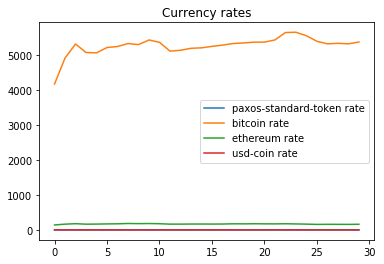

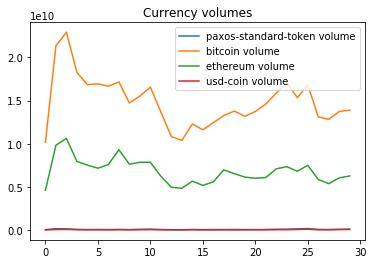

In [55]:
import pandas as pd
from selenium import webdriver
import itertools
import time
import re

class CryptoHistory():
    def __init__(self, file_path = 'C:\\chromedriver.exe'):
        self.file_path = file_path
        self.startDriver()
        self.getUrls()

    def striplist(self, list):
        return([x.replace(' ', '') for x in list])

    def startDriver(self):
        option = webdriver.ChromeOptions()
        option.add_argument(" — incognito")
        browser = webdriver.Chrome(executable_path=self.file_path)
        browser.get("https://coinmarketcap.com/exchanges/bitmax/")
        self.browser = browser

    def getUrls(self):
        urls = []
        infos = self.browser.find_elements_by_class_name('margin-left--lv1')
        urls = [(url.get_attribute("href") + "historical-data") for url in infos]
        mainUrls = []
        for item in urls:
            if re.search("bitcoin/|paxos|ethereum/|usd-coin", item):
                mainUrls.append(item)
        mainUrls = set(mainUrls)
        self.urls = mainUrls
        currencyNames = []
        for item in mainUrls:
            currencyNames.append((re.findall('currencies/(\w+-?\w+-?\w+)/historical-data', item)[0]))
        self.currencyNames = currencyNames
        
    def currHistory(self, url):
        self.browser.get(url)
#         time.sleep(5)
        exchange_lists = []
        curr_tab = self.browser.find_elements_by_xpath('//table[@class="table"]//tr')
        exchange_lists = [(td.text for td in tr.find_elements_by_xpath(".//*[self::td or self::th]")) for tr in curr_tab]
        df = pd.DataFrame(exchange_lists)
        df.columns = df.iloc[0]
        df = df.reindex(df.index.drop(0))
        df.sort_index(inplace = True, ascending = False)

        high_price = self.striplist(list(df.iloc[:,2].transpose()))
        volume = self.striplist(list(df.iloc[:,5].transpose()))
        return high_price, volume

    def historyToDataFrames(self):
        prices = []
        volumes = []
        
        for url in self.urls:
            price, volume = self.currHistory(url)
            prices.append(price)
            volumes.append(volume)
        
        df_prices = pd.DataFrame(prices).transpose()
        ratesColnames = [s + ' rate' for s in self.currencyNames]
        df_prices.columns = ratesColnames
        df_volumes = pd.DataFrame(volumes).transpose()
        volumesColnames = [s + ' volume' for s in self.currencyNames]
        df_volumes.columns = volumesColnames
        
        self.df_prices = df_prices
        self.df_volumes = df_volumes

    def plotHistoryData(self):
        df_prices = testObject.df_prices.apply(lambda x: x.str.replace(',','.').astype(float))
        df_prices.plot(title = 'Currency rates')
        df_volumes = testObject.df_volumes.apply(lambda x: x.str.replace(',','.').astype(float))
        df_volumes.plot(title = 'Currency volumes')
        
testObject = CryptoHistory(file_path = 'C:\\chromedriver.exe')
testObject.historyToDataFrames()
testObject.plotHistoryData()

In [56]:
testObject.df_prices

,paxos-standard-token rate,bitcoin rate,ethereum rate,usd-coin rate
0,"1,01","4164,95","142,73","1,01"
1,"1,01","4905,95","165,23","1,02"
2,"1,02","5307,00","178,32","1,02"
3,"1,01","5063,16","164,93","1,01"
4,"1,00","5053,51","167,22","1,01"
5,"1,01","5205,82","172,52","1,01"
6,"1,01","5235,19","175,21","1,01"
7,"1,00","5318,84","184,38","1,01"
8,"1,00","5289,92","180,25","1,00"
9,"1,02","5421,65","183,13","1,01"
